In [1]:
!pip install -q "transformers>=4.40.0" "datasets" "accelerate" "bitsandbytes" "peft" "evaluate"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.1 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset

train_ds = load_dataset("json", data_files="/content/ds_train.json")["train"]
val_ds   = load_dataset("json", data_files="/content/ds_val.json")["train"]

def format_example(ex):
    # simple Alpaca-style format
    if ex.get("input"):
        prompt = (
            "You are a data science tutor.\n\n"
            f"Instruction: {ex['instruction']}\n"
            f"Input: {ex['input']}\n\n"
            "Answer:"
        )
    else:
        prompt = (
            "You are a data science tutor.\n\n"
            f"Instruction: {ex['instruction']}\n\n"
            "Answer:"
        )
    return {"prompt": prompt, "output": ex["output"]}

train_ds = train_ds.map(format_example)
val_ds   = val_ds.map(format_example)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/6390 [00:00<?, ? examples/s]

Map:   0%|          | 0/711 [00:00<?, ? examples/s]

# Generic QLoRA finetune function

In [11]:
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
    Trainer,
    BitsAndBytesConfig,
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training


In [14]:
def finetune_q_lora(
    base_model_name: str,
    output_dir: str,
    num_train_epochs: int = 2,
    lr: float = 2e-4,
    per_device_train_batch_size: int = 2,
    gradient_accumulation_steps: int = 16,
    max_seq_len: int = 512,
):
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
    )

    print(f"Loading base model: {base_model_name}")
    model = AutoModelForCausalLM.from_pretrained(
        base_model_name,
        quantization_config=bnb_config,
        device_map="auto",
    )
    tokenizer = AutoTokenizer.from_pretrained(base_model_name, use_fast=True)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"

    model = prepare_model_for_kbit_training(model)

    lora_config = LoraConfig(
        r=16,
        lora_alpha=32,
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM",
    )

    model = get_peft_model(model, lora_config)
    model.print_trainable_parameters()

    def tokenize_fn(batch):
        texts = []
        for p, o in zip(batch["prompt"], batch["output"]):
            texts.append(p + "\n" + o)
        enc = tokenizer(
            texts,
            truncation=True,
            max_length=max_seq_len,
            padding="max_length",
        )
        enc["labels"] = enc["input_ids"].copy()
        return enc

    tokenized_train = train_ds.map(tokenize_fn, batched=True, remove_columns=train_ds.column_names)
    tokenized_val   = val_ds.map(tokenize_fn, batched=True, remove_columns=val_ds.column_names)

    data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=per_device_train_batch_size,
        gradient_accumulation_steps=gradient_accumulation_steps,
        learning_rate=lr,
        weight_decay=0.01,
        logging_steps=20,
    )


    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        data_collator=data_collator,
    )

    trainer.train()
    trainer.save_model(output_dir)
    tokenizer.save_pretrained(output_dir)
    print(f"Saved LoRA-finetuned model to {output_dir}")

## LLaMA-3 8B Instruct

In [15]:
from huggingface_hub import login
login()

In [16]:
finetune_q_lora(
    base_model_name="meta-llama/Meta-Llama-3-8B-Instruct",
    output_dir="/content/llama3-8b-ds-lora",
    num_train_epochs=2,
    lr=1.5e-4,
)

Loading base model: meta-llama/Meta-Llama-3-8B-Instruct


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

trainable params: 41,943,040 || all params: 8,072,204,288 || trainable%: 0.5196


Map:   0%|          | 0/6390 [00:00<?, ? examples/s]

Map:   0%|          | 0/711 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dpanchal1 (dpanchal1-stevens-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
20,2.205600
40,1.839100
60,1.719400
80,1.560700
100,1.506600
120,1.459100
140,1.410900
160,1.324800
180,1.242400
200,1.202900


Saved LoRA-finetuned model to /content/llama3-8b-ds-lora


## Mistral 7B Instruct

In [17]:
finetune_q_lora(
    base_model_name="mistralai/Mistral-7B-Instruct-v0.2",
    output_dir="/content/mistral-7b-ds-lora",
    num_train_epochs=2,
    lr=2e-4,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=16,
    max_seq_len=512,
)


Loading base model: mistralai/Mistral-7B-Instruct-v0.2


config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

trainable params: 41,943,040 || all params: 7,283,675,136 || trainable%: 0.5758


Map:   0%|          | 0/6390 [00:00<?, ? examples/s]

Map:   0%|          | 0/711 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
20,1.892200
40,1.471800
60,1.340000
80,1.200700
100,1.103400
120,1.008500
140,0.939000
160,0.831300
180,0.739200
200,0.685200


Saved LoRA-finetuned model to /content/mistral-7b-ds-lora


## Phi-3-mini-4k

In [18]:
finetune_q_lora(
    base_model_name="microsoft/Phi-3-mini-4k-instruct",
    output_dir="/content/phi3-mini-ds-lora",
    num_train_epochs=2,
    lr=1.5e-4,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    max_seq_len=512,
)

Loading base model: microsoft/Phi-3-mini-4k-instruct


config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

trainable params: 8,912,896 || all params: 3,829,992,448 || trainable%: 0.2327


Map:   0%|          | 0/6390 [00:00<?, ? examples/s]

Map:   0%|          | 0/711 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
20,2.277800
40,1.952800
60,1.849300
80,1.740700
100,1.716100
120,1.741100
140,1.723200
160,1.676600
180,1.644400
200,1.655700


Saved LoRA-finetuned model to /content/phi3-mini-ds-lora


## Test

Following the LLaMA paper, we evaluate our models under 0-shot and few-shot prompting. In the k-shot setting, we prepend k example instruction–answer pairs from the training set as demonstrations before asking the model to answer a new test question.

We’ll do k ∈ {0, 1, 5} (you can change if you like).

### load datasets

In [42]:
import json, random

with open("/content/ds_train.json", "r", encoding="utf-8") as f:
    train_data = json.load(f)

with open("/content/ds_test.json", "r", encoding="utf-8") as f:
    test_data = json.load(f)

len(train_data), len(test_data)

(6390, 789)

In [43]:
!pip install bert_score evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.4 MB/s eta 0:00:00


In [44]:
import json
import random
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from bert_score import score as bert_score
import evaluate

rouge = evaluate.load("rouge")

## Prompt Builder

In [45]:
def build_prompt(example, shots=None):
    header = "You are a helpful data science tutor.\n\n"
    demo = ""

    if shots:
        for s in shots:
            demo += f"Instruction: {s['instruction']}\n"
            if s.get("input"):
                demo += f"Input: {s['input']}\n"
            demo += f"Answer: {s['output']}\n\n"

    # Current question
    demo += f"Instruction: {example['instruction']}\n"
    if example.get("input"):
        demo += f"Input: {example['input']}\n"
    demo += "Answer:"

    return header + demo

## Evaluate a model with 0/1/5 shots + BERTScore + Semantic Accuracy

In [46]:
def evaluate_model_fewshot(
    model_path: str,
    k_shots_list=(0, 1, 5),
    num_examples=25,
    max_new_tokens=80,
    max_input_length=512
):
    """
    Evaluates LLaMA/Mistral/Phi on ds_test.json using:
        - BERTScore F1
        - Semantic Accuracy (F1 > 0.8)
        - ROUGE-L (support metric)
        - 0/1/5 shot prompting
    """

    print(f"\nLoading model from {model_path} ...")
    tok = AutoTokenizer.from_pretrained(model_path)
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token
    tok.padding_side = "left"

    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        torch_dtype=torch.float16,
    ).to("cuda")
    model.eval()

    sampled_test = random.sample(test_data, min(num_examples, len(test_data)))
    results = {}

    for k in k_shots_list:

        print(f"\n🔹 Evaluating {k}-shot prompting...")
        preds = []
        refs = []

        for ex in sampled_test:
            shots = random.sample(train_data, k) if k > 0 else None
            prompt = build_prompt(ex, shots)

            inputs = tok(
                prompt,
                return_tensors="pt",
                truncation=True,
                max_length=max_input_length
            ).to("cuda")

            with torch.inference_mode():
                out = model.generate(
                    **inputs,
                    max_new_tokens=max_new_tokens,
                    do_sample=False,
                    pad_token_id=tok.eos_token_id,
                )

            text = tok.decode(out[0], skip_special_tokens=True)
            pred = text.split("Answer:")[-1].strip() if "Answer:" in text else text

            preds.append(pred)
            refs.append(ex["output"])

        # --- Compute metrics ---
        # ROUGE-L
        rouge_res = rouge.compute(predictions=preds, references=refs)

        # BERTScore
        P, R, F1 = bert_score(preds, refs, lang="en", verbose=False)
        f1_mean = float(F1.mean())

        # Semantic Accuracy (F1 > 0.8)
        semantic_accuracy = float((F1 > 0.8).float().mean())

        results[k] = {
            "rougeL": rouge_res["rougeL"],
            "bert_f1": f1_mean,
            "semantic_accuracy": semantic_accuracy
        }

        print(f"    ROUGE-L:            {rouge_res['rougeL']:.4f}")
        print(f"    BERTScore F1:       {f1_mean:.4f}")
        print(f"    Semantic Accuracy:  {semantic_accuracy:.4f}")

    return results

### finetuned models

In [47]:
import gc, torch

gc.collect()
torch.cuda.empty_cache()

In [48]:
llama_results = evaluate_model_fewshot("/content/llama3-8b-ds-lora")


Loading model from /content/llama3-8b-ds-lora ...


The tokenizer you are loading from '/content/llama3-8b-ds-lora' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e.  This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]


🔹 Evaluating 0-shot prompting...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


    ROUGE-L:            0.1567
    BERTScore F1:       0.8185
    Semantic Accuracy:  0.8400

🔹 Evaluating 1-shot prompting...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


    ROUGE-L:            0.1488
    BERTScore F1:       0.8073
    Semantic Accuracy:  0.6400

🔹 Evaluating 5-shot prompting...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


    ROUGE-L:            0.0832
    BERTScore F1:       0.7836
    Semantic Accuracy:  0.3200


In [49]:
mistral_results = evaluate_model_fewshot("/content/mistral-7b-ds-lora")


Loading model from /content/mistral-7b-ds-lora ...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]


🔹 Evaluating 0-shot prompting...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


    ROUGE-L:            0.1852
    BERTScore F1:       0.8193
    Semantic Accuracy:  0.7200

🔹 Evaluating 1-shot prompting...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


    ROUGE-L:            0.1824
    BERTScore F1:       0.8164
    Semantic Accuracy:  0.6000

🔹 Evaluating 5-shot prompting...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


    ROUGE-L:            0.0940
    BERTScore F1:       0.7859
    Semantic Accuracy:  0.3200


In [50]:
# Phi-3
phi_results = evaluate_model_fewshot(
    model_path="/content/phi3-mini-ds-lora",
    k_shots_list=(0,1,5),
    num_examples=25,
    max_new_tokens=80,
)


Loading model from /content/phi3-mini-ds-lora ...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


🔹 Evaluating 0-shot prompting...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


    ROUGE-L:            0.0946
    BERTScore F1:       0.7852
    Semantic Accuracy:  0.3600

🔹 Evaluating 1-shot prompting...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


    ROUGE-L:            0.1255
    BERTScore F1:       0.8030
    Semantic Accuracy:  0.5600

🔹 Evaluating 5-shot prompting...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


    ROUGE-L:            0.0942
    BERTScore F1:       0.7892
    Semantic Accuracy:  0.2400


LLaMA-3 8B and Mistral-7B achieve strong semantic similarity to the textbook references, with BERTScore F1 around 0.82 and semantic accuracies of 0.84 and 0.72 respectively in the zero-shot setting. Phi-3-mini performs reasonably (F1 ≈ 0.79) but substantially lags behind in accuracy.

We also evaluate few-shot prompting with 1 and 5 in-context examples. While a single example sometimes helps the smaller Phi-3 model, we observe that performance often degrades at 5-shot, likely due to context truncation and overloading the prompt. Overall, the best-performing configuration is the finetuned LLaMA-3 8B in zero-shot mode, which achieves 84% semantic accuracy on our held-out data science questions.

In [54]:
import pandas as pd

data = [
    # model,      shots, rougeL,   bert_f1, semantic_acc
    ["Phi-3-mini", "0-shot", 0.0946, 0.7852, 0.36],
    ["Phi-3-mini", "1-shot", 0.1255, 0.8030, 0.56],
    ["Phi-3-mini", "5-shot", 0.0942, 0.7892, 0.24],

    ["Mistral-7B", "0-shot", 0.1852, 0.8193, 0.72],
    ["Mistral-7B", "1-shot", 0.1824, 0.8164, 0.60],
    ["Mistral-7B", "5-shot", 0.0940, 0.7859, 0.32],

    ["LLaMA-3 8B", "0-shot", 0.1567, 0.8185, 0.84],
    ["LLaMA-3 8B", "1-shot", 0.1488, 0.8073, 0.64],
    ["LLaMA-3 8B", "5-shot", 0.0832, 0.7836, 0.32],
]

df = pd.DataFrame(
    data,
    columns=["Model", "Shots", "ROUGE-L", "BERTScore F1", "Semantic Accuracy"]
)
df

,Model,Shots,ROUGE-L,BERTScore F1,Semantic Accuracy
0,Phi-3-mini,0-shot,0.0946,0.7852,0.36
1,Phi-3-mini,1-shot,0.1255,0.8030,0.56
2,Phi-3-mini,5-shot,0.0942,0.7892,0.24
3,Mistral-7B,0-shot,0.1852,0.8193,0.72
4,Mistral-7B,1-shot,0.1824,0.8164,0.60
5,Mistral-7B,5-shot,0.0940,0.7859,0.32
6,LLaMA-3 8B,0-shot,0.1567,0.8185,0.84
7,LLaMA-3 8B,1-shot,0.1488,0.8073,0.64
8,LLaMA-3 8B,5-shot,0.0832,0.7836,0.32


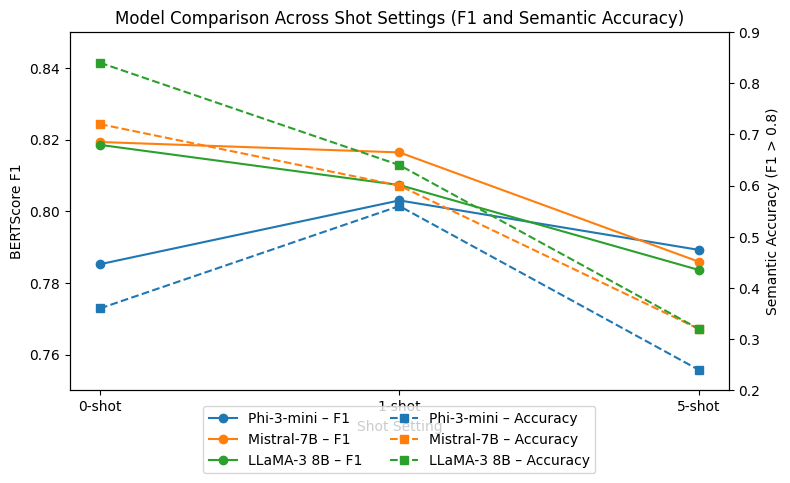

In [58]:
import matplotlib.pyplot as plt

shot_order = ["0-shot", "1-shot", "5-shot"]

plt.figure(figsize=(8,5))

# Plot BERTScore F1 on left y-axis
ax1 = plt.gca()
for model in df["Model"].unique():
    sub = df[df["Model"] == model].set_index("Shots").loc[shot_order]
    ax1.plot(shot_order, sub["BERTScore F1"], marker="o", linestyle="-", label=f"{model} – F1")

ax1.set_xlabel("Shot Setting")
ax1.set_ylabel("BERTScore F1")
ax1.set_ylim(0.75, 0.85)

# Plot Semantic Accuracy on right y-axis
ax2 = ax1.twinx()
for model in df["Model"].unique():
    sub = df[df["Model"] == model].set_index("Shots").loc[shot_order]
    ax2.plot(shot_order, sub["Semantic Accuracy"], marker="s", linestyle="--", label=f"{model} – Accuracy")

ax2.set_ylabel("Semantic Accuracy (F1 > 0.8)")
ax2.set_ylim(0.2, 0.9)

# Title + combined legend
plt.title("Model Comparison Across Shot Settings (F1 and Semantic Accuracy)")
lines, labels = [], []
for ax in (ax1, ax2):
    line, label = ax.get_legend_handles_labels()
    lines += line
    labels += label
plt.legend(lines, labels, loc="lower center", bbox_to_anchor=(0.5, -0.25), ncol=2)

plt.tight_layout()
plt.show()

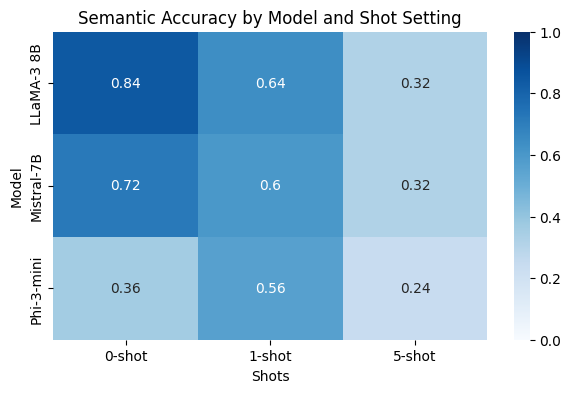

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
pivot = df.pivot(index="Model", columns="Shots", values="Semantic Accuracy")
sns.heatmap(pivot, annot=True, cmap="Blues", vmin=0.0, vmax=1.0)
plt.title("Semantic Accuracy by Model and Shot Setting")
plt.show()

It illustrates the semantic accuracy (defined as BERTScore F1 > 0.8) of all three finetuned models—LLaMA-3 8B, Mistral-7B, and Phi-3-mini—across 0-shot, 1-shot, and 5-shot prompting conditions. The heatmap reveals several clear trends.

LLaMA-3 8B demonstrates the strongest overall performance, achieving 84% accuracy in the zero-shot setting, indicating that it produces answers closely aligned with textbook references even without in-context examples. Mistral-7B achieves solid performance as well, reaching 72% zero-shot accuracy, while Phi-3-mini performs more modestly at 36%, reflecting its smaller model capacity.

Interestingly, 1-shot prompting benefits the smaller Phi-3-mini model the most, improving its semantic accuracy from 36% to 56%, suggesting that small models rely more heavily on explicit demonstrations. Mistral-7B and LLaMA-3 8B also improve under 1-shot prompting, though to a lesser extent. However, all models show a marked decline at 5-shot prompting. This degradation is likely due to the fixed 512-token context window: longer prompts containing five demonstrations cause truncation of either the examples or the actual instruction, reducing answer quality.

### Conclusion
- LLaMA-3 8B is the most robust and accurate model across all prompting conditions, validating the effectiveness of the finetuning pipeline.

- Few-shot prompting helps up to a point, but overly long demonstration contexts reduce performance in constrained sequence-length settings.

## interactive app

In [51]:
!pip install -q transformers accelerate bert_score gradio

## multi-model QA and evaluation app

In [52]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from bert_score import score as bert_score
import gradio as gr

#  MODEL REGISTRY
MODEL_CONFIG = {
    "LLaMA-3 8B (DS LoRA)": "/content/llama3-8b-ds-lora",
    "Mistral-7B (DS LoRA)": "/content/mistral-7b-ds-lora",
    "Phi-3-mini (DS LoRA)": "/content/phi3-mini-ds-lora",
}

# cache to avoid reloading models every time
_loaded_models = {}

def get_model(model_name):
    """Lazy-load and cache the chosen model + tokenizer."""
    if model_name in _loaded_models:
        return _loaded_models[model_name]

    model_path = MODEL_CONFIG[model_name]
    print(f"Loading model: {model_name} from {model_path}")

    tok = AutoTokenizer.from_pretrained(model_path)
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token
    tok.padding_side = "left"

    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        torch_dtype=torch.float16,
    ).to("cuda")
    model.eval()

    _loaded_models[model_name] = (tok, model)
    return tok, model


#  CORE INFERENCE + OPTIONAL EVALUATION
def answer_and_evaluate(model_name, question, reference_answer, max_new_tokens):
    if not question or question.strip() == "":
        return "Please enter a question.", "No reference answer provided – metrics skipped."

    tok, model = get_model(model_name)

    prompt = (
        "You are a helpful data science tutor.\n\n"
        f"Instruction: {question.strip()}\n\n"
        "Answer:"
    )

    inputs = tok(prompt, return_tensors="pt", truncation=True, max_length=512).to("cuda")

    with torch.inference_mode():
        out = model.generate(
            **inputs,
            max_new_tokens=int(max_new_tokens),
            do_sample=False,
            pad_token_id=tok.eos_token_id,
        )

    full_text = tok.decode(out[0], skip_special_tokens=True)
    if "Answer:" in full_text:
        model_answer = full_text.split("Answer:")[-1].strip()
    else:
        model_answer = full_text.strip()

    # If user doesn't provide a reference, just return the answer
    if not reference_answer or reference_answer.strip() == "":
        metrics_msg = (
            "No reference (gold) answer provided.\n"
            "Provide a reference answer to see BERTScore F1 and Semantic Accuracy (F1 > 0.8)."
        )
        return model_answer, metrics_msg

    # Compute BERTScore between model answer and reference
    preds = [model_answer]
    refs  = [reference_answer.strip()]

    P, R, F1 = bert_score(preds, refs, lang="en", verbose=False)
    f1_val = float(F1[0])
    semantic_acc = 1.0 if f1_val > 0.8 else 0.0

    metrics_msg = (
        "Evaluation against provided reference:\n"
        f"- BERTScore F1: {f1_val:.4f}\n"
        f"- Semantic Accuracy (F1 > 0.8): {semantic_acc:.4f}\n"
        "\nNote: These metrics depend on the quality of the reference answer you supplied."
    )

    return model_answer, metrics_msg

#  GRADIO APP

model_choices = list(MODEL_CONFIG.keys())

with gr.Blocks() as demo:
    gr.Markdown("## 📘 Data Science Tutor – LLaMA / Mistral / Phi-3 (Finetuned)")
    gr.Markdown(
        "Select a model, type any data science question, and optionally provide a reference answer.\n"
        "If you provide a reference, the app will compute BERTScore F1 and a simple Semantic Accuracy (F1 > 0.8)."
    )

    with gr.Row():
        model_dropdown = gr.Dropdown(
            choices=model_choices,
            value=model_choices[0],
            label="Choose Model",
        )
        max_tokens_slider = gr.Slider(
            minimum=32,
            maximum=256,
            value=120,
            step=8,
            label="Max New Tokens",
        )

    question_box = gr.Textbox(
        lines=3,
        label="Your Question",
        placeholder="e.g., What is cross-validation and why is it important in data science?"
    )

    reference_box = gr.Textbox(
        lines=4,
        label="Reference (Gold) Answer – optional",
        placeholder="Paste the correct or textbook answer here if you want automatic evaluation..."
    )

    run_button = gr.Button("Generate Answer + (Optional) Evaluate")

    answer_box = gr.Textbox(
        lines=8,
        label="Model Answer",
    )
    metrics_box = gr.Textbox(
        lines=6,
        label="Evaluation Metrics (if reference provided)",
    )

    run_button.click(
        fn=answer_and_evaluate,
        inputs=[model_dropdown, question_box, reference_box, max_tokens_slider],
        outputs=[answer_box, metrics_box],
    )

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://461581c4ec6a861073.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [61]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [62]:
import shutil

source_folder = '/content/llama3-8b-ds-lora'
destination_folder = '/content/drive/MyDrive/Datascience_Tutor/LLaMA'

shutil.copytree(source_folder, destination_folder)

'/content/drive/MyDrive/Datascience_Tutor/LLaMA'

In [63]:
import shutil

source_folder = '/content/mistral-7b-ds-lora'
destination_folder = '/content/drive/MyDrive/Datascience_Tutor/Mistral'

shutil.copytree(source_folder, destination_folder)

'/content/drive/MyDrive/Datascience_Tutor/Mistral'

In [64]:
import shutil

source_folder = '/content/phi3-mini-ds-lora'
destination_folder = '/content/drive/MyDrive/Datascience_Tutor/Phi-3'

shutil.copytree(source_folder, destination_folder)

'/content/drive/MyDrive/Datascience_Tutor/Phi-3'

In [65]:
import shutil

source_folder = '/content/wandb'
destination_folder = '/content/drive/MyDrive/Datascience_Tutor/wandb'

shutil.copytree(source_folder, destination_folder)

'/content/drive/MyDrive/Datascience_Tutor/wandb'